In [1]:
import torch
import argparse
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class UpSampling(nn.Module):
    def __init__(self, in_ch, out_ch, stride, padding = -1):
        super(UpSampling, self).__init__()
        self.in_ch = in_ch
        self.stride = stride
        self.ksize = self.stride * 2
        self.out_ch = out_ch
        if padding < 0:
            self.padding = int(self.stride / 2)
        else:
            self.padding = padding
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.in_ch, out_channels=2, stride=self.stride,
                                        kernel_size = self.ksize, padding = self.padding),
            nn.BatchNorm2d(2),
            nn.ReLU(inplace=True),
        )
        self.out = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=self.out_ch, kernel_size=1),
            nn.BatchNorm2d(self.out_ch),
            # nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.out(x)
        return x
    

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class DCAN(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DCAN, self).__init__()
        self.n_channels = in_ch
        self.n_classes = out_ch
        
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)        
        self.up3_mask = UpSampling(512, 1, 8)
        self.up3_contour = UpSampling(512, 1, 8)
        
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 512)
        self.up2_mask = UpSampling(512, 1, 16)
        self.up2_contour = UpSampling(512, 1, 16)
          
        self.pool5 = nn.MaxPool2d(2)
        self.conv6 = DoubleConv(512, 1024)
        self.up1_mask = UpSampling(1024, 1, 32)
        self.up1_contour = UpSampling(1024, 1, 32)
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        mask3 = self.up3_mask(c4)
        contour3 = self.up3_contour(c4)
        
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        mask2 = self.up2_mask(c5)
        contour2 = self.up2_contour(c5)
        
        p5=self.pool5(c5)
        c6=self.conv6(p5)
        mask1 = self.up1_mask(c6)
        contour1 = self.up1_contour(c6)
        
        mask = self.relu(mask1 + mask2 + mask3)
        contour = self.relu(contour1 + contour2 + contour3)

        return mask, contour

In [5]:
def make_dataset(root):
    imgs=[]
    n=len(os.listdir(root))//3
    for i in range(n):
        img=os.path.join(root,"%03d.png"%i)
        mask=os.path.join(root,"%03d_mask.png"%i)
        contour=os.path.join(root,"%03d_contour.png"%i)
        imgs.append((img,mask,contour))
    return imgs


class LiverDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x_path, y1_path, y2_path = self.imgs[index]
        img_x = Image.open(x_path)
        img_y1 = Image.open(y1_path)
        img_y2 = Image.open(y2_path)
        img_y2 = img_y2.convert('L')

        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y2 = self.target_transform(img_y2)
            img_y1 = self.target_transform(img_y1)
        return img_x, img_y1, img_y2

    def __len__(self):
        return len(self.imgs)

In [6]:
x_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

y_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
])

In [7]:
# liver_dataset = LiverDataset("u_net_liver/data/data/train", transform=x_transforms,target_transform=y_transforms)

In [8]:
def train_model(model, criterion, optimizer, dataload, w_contour=1, num_epochs=20):
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        
        for x, y_mask, y_contour in dataload:
            step += 1
            inputs = x.to(device)
            labels_contour = y_contour.to(device)
            labels_mask = y_mask.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            mask_pred, contour_pred = model(inputs)
            loss_mask = criterion(mask_pred, labels_mask)
            loss_contour = w_contour * criterion(contour_pred, labels_contour)

            loss = (loss_mask + loss_contour)/(1 + w_contour)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [9]:
model = DCAN(3, 1).to(device)
batch_size = 2
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
liver_dataset = LiverDataset("u_net_liver/data/data/train",transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_model(model, criterion, optimizer, dataloaders, num_epochs=4)

Epoch 0/3
----------
1/200,train_loss:0.823
2/200,train_loss:0.761
3/200,train_loss:0.728
4/200,train_loss:0.727
5/200,train_loss:0.716
6/200,train_loss:0.720
7/200,train_loss:0.708
8/200,train_loss:0.709
9/200,train_loss:0.712
10/200,train_loss:0.704
11/200,train_loss:0.706
12/200,train_loss:0.707
13/200,train_loss:0.699
14/200,train_loss:0.702
15/200,train_loss:0.707
16/200,train_loss:0.708
17/200,train_loss:0.697
18/200,train_loss:0.697
19/200,train_loss:0.692
20/200,train_loss:0.696
21/200,train_loss:0.692
22/200,train_loss:0.688
23/200,train_loss:0.689
24/200,train_loss:0.688
25/200,train_loss:0.688
26/200,train_loss:0.699
27/200,train_loss:0.690
28/200,train_loss:0.685
29/200,train_loss:0.687
30/200,train_loss:0.686
31/200,train_loss:0.686
32/200,train_loss:0.689
33/200,train_loss:0.691
34/200,train_loss:0.686
35/200,train_loss:0.694
36/200,train_loss:0.694
37/200,train_loss:0.695
38/200,train_loss:0.685
39/200,train_loss:0.692
40/200,train_loss:0.689
41/200,train_loss:0.685
42/2

135/200,train_loss:0.676
136/200,train_loss:0.680
137/200,train_loss:0.679
138/200,train_loss:0.682
139/200,train_loss:0.685
140/200,train_loss:0.679
141/200,train_loss:0.675
142/200,train_loss:0.681
143/200,train_loss:0.678
144/200,train_loss:0.678
145/200,train_loss:0.683
146/200,train_loss:0.680
147/200,train_loss:0.677
148/200,train_loss:0.674
149/200,train_loss:0.673
150/200,train_loss:0.676
151/200,train_loss:0.672
152/200,train_loss:0.671
153/200,train_loss:0.677
154/200,train_loss:0.672
155/200,train_loss:0.692
156/200,train_loss:0.676
157/200,train_loss:0.676
158/200,train_loss:0.670
159/200,train_loss:0.673
160/200,train_loss:0.685
161/200,train_loss:0.671
162/200,train_loss:0.676
163/200,train_loss:0.678
164/200,train_loss:0.685
165/200,train_loss:0.683
166/200,train_loss:0.675
167/200,train_loss:0.682
168/200,train_loss:0.683
169/200,train_loss:0.672
170/200,train_loss:0.724
171/200,train_loss:0.677
172/200,train_loss:0.679
173/200,train_loss:0.675
174/200,train_loss:0.675


67/200,train_loss:0.663
68/200,train_loss:0.674
69/200,train_loss:0.674
70/200,train_loss:0.676
71/200,train_loss:0.674
72/200,train_loss:0.666
73/200,train_loss:0.668
74/200,train_loss:0.669
75/200,train_loss:0.681
76/200,train_loss:0.677
77/200,train_loss:0.676
78/200,train_loss:0.676
79/200,train_loss:0.672
80/200,train_loss:0.678
81/200,train_loss:0.677
82/200,train_loss:0.686
83/200,train_loss:0.668
84/200,train_loss:0.661
85/200,train_loss:0.654
86/200,train_loss:0.686
87/200,train_loss:0.664
88/200,train_loss:0.687
89/200,train_loss:0.670
90/200,train_loss:0.681
91/200,train_loss:0.670
92/200,train_loss:0.665
93/200,train_loss:0.663
94/200,train_loss:0.677
95/200,train_loss:0.667
96/200,train_loss:0.676
97/200,train_loss:0.683
98/200,train_loss:0.665
99/200,train_loss:0.663
100/200,train_loss:0.666
101/200,train_loss:0.666
102/200,train_loss:0.680
103/200,train_loss:0.674
104/200,train_loss:0.664
105/200,train_loss:0.681
106/200,train_loss:0.663
107/200,train_loss:0.686
108/200,

DCAN(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool2): MaxPool

In [1]:
model = model.cpu()

NameError: name 'model' is not defined

In [11]:
def make_dataset(root):
    imgs=[]
    n=len(os.listdir(root))//3
    for i in range(n):
        img=os.path.join(root,"%03d.png"%i)
        mask=os.path.join(root,"%03d_mask.png"%i)
        imgs.append((img,mask))
    return imgs


class LiverDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x_path, y_path = self.imgs[index]
        img_x = Image.open(x_path)
        img_y = Image.open(y_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)

In [12]:
liver_dataset = LiverDataset("u_net_liver/data/data/val", transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=1)

In [13]:
def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    import numpy as np
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    return np.sum(intersection) / np.sum(union)

In [15]:
IoU = 0
n = 0
with torch.no_grad():
    for x, target in dataloaders:
        n = n + 1
        y = model(x)
        y_pred = torch.squeeze(y[0] + y[1]).numpy() > 0.5
        y_true = torch.squeeze(target).numpy()
        print(meanIOU_per_image(y_pred, y_true))
        IoU = IoU + meanIOU_per_image(y_pred, y_true)
print(IoU/n)

0.7327823691460055
0.7272727272727273
0.722341491341062
0.725818507998206
0.7249265955802813
0.7338152610441767
0.7303426585002483
0.7087152141309782
0.6876374090985963
0.696236559139785
0.7020116563263772
0.7167571917119292
0.7350575961747446
0.7187473259588552


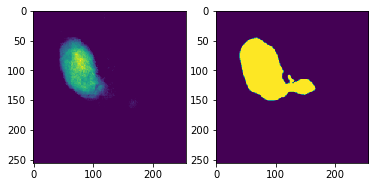

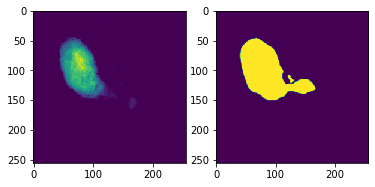

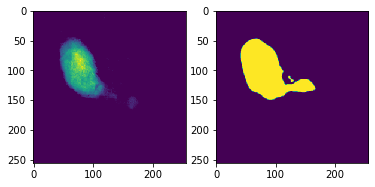

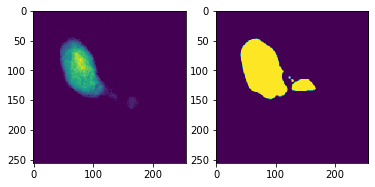

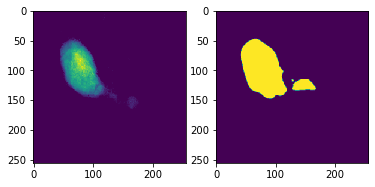

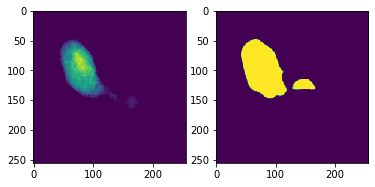

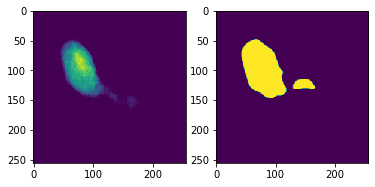

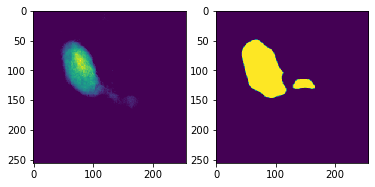

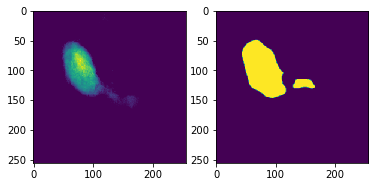

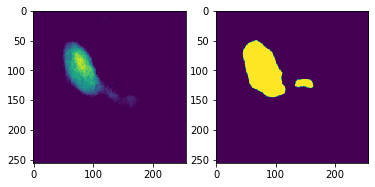

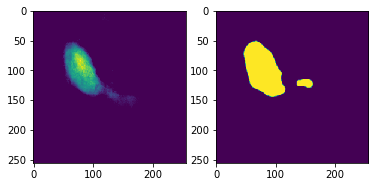

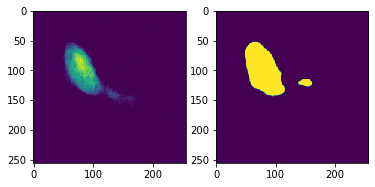

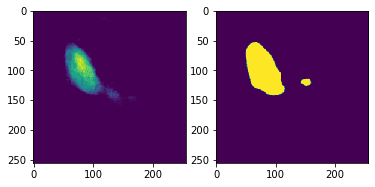

In [14]:
plt.ion()
with torch.no_grad():
    for x,label in dataloaders:
        y=model(x)
        img_y=torch.squeeze(y[0] + y[1]).numpy()
        img_label = torch.squeeze(label).numpy()  
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(img_y)
        plt.subplot(1,2,2)
        plt.imshow(img_label)
        plt.pause(0.01)
    plt.show()